This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [55]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [56]:
import pandas as pd
import numpy as np

N = 150000
file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name, header = 0,nrows = N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
149995,1,1,108,3869201660,1085,11
149996,1,1,103,3869201660,1085,5
149997,1,1,105,3869201660,1088,19
149998,1,1,104,3869201660,1095,15


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [57]:
orbit = pd.Series(data['ORBIT_CNT'])
bx_counter = pd.Series(data['BX_COUNTER'])
x = []
inf_bx = bx_counter[0]
for i in range(0,len(orbit)-1):
    change = orbit[i+1]-orbit[i]
    if change != 0:
        sup_bx = bx_counter[i]
        x.append(sup_bx-inf_bx)
        inf_bx = bx_counter[i+1]
        
print("Max of x with " + str(N) + " samples: " + str(max(x)+1))

# We have to add 1 to max(x) because if we consider a digital timer, after the last sample the count is reset.
# For example, if we imagine, a digital clock, after the 59th second the minut clicks. However, a minut is composed
# by 60 seconds. For the same reason we have to add 1 to max(x).

Max of x with 150000 samples: 3564


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [58]:
import datetime as dt

M = max(x)+1

# Time values for the first sample
first_orbit = data.loc[data.index[0],'ORBIT_CNT']
first_bx = data.loc[data.index[0],'BX_COUNTER']
first_tdc = data.loc[data.index[0],'TDC_MEAS']

# Time values for the last sample
last_orbit = data.loc[data.index[N-1],'ORBIT_CNT']
last_bx = data.loc[data.index[N-1],'BX_COUNTER']
last_tdc = data.loc[data.index[N-1],'TDC_MEAS']

# Coversion of all values in s
first_tot_sec = first_tdc*(25/30)*10**-9 + first_bx*25*10**-9 + M*first_orbit*25*10**-9
last_tot_sec = last_tdc*(25/30)*10**-9 + last_bx*25*10**-9 + M*last_orbit*25*10**-9

# Computing hours, minutes, seconds
elapsed_time = last_tot_sec-first_tot_sec
elapsed_time = dt.timedelta(seconds=elapsed_time)
print("Elapsed time: " + str(elapsed_time))

Elapsed time: 0:00:00.132994


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [59]:
def absolute_time(data):
    result = []
    
    # Beginning in ns
    start = data.loc[data.index[0],'ORBIT_CNT']*M*25 + data.loc[data.index[0],'BX_COUNTER']*25 + data.loc[data.index[0],'TDC_MEAS']*(25/30)
    for i in range(len(data)):
        # Current time
        curr = data.loc[data.index[i],'ORBIT_CNT']*M*25 + data.loc[data.index[i],'BX_COUNTER']*25 + data.loc[data.index[i],'TDC_MEAS']*(25/30)
        
        # Store the time difference
        result.append(curr-start)
        
    return result

data['TIMENS'] = absolute_time(data)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIMENS
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649125e+03
...,...,...,...,...,...,...,...
149995,1,1,108,3869201660,1085,11,1.329941e+08
149996,1,1,103,3869201660,1085,5,1.329941e+08
149997,1,1,105,3869201660,1088,19,1.329941e+08
149998,1,1,104,3869201660,1095,15,1.329943e+08


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [60]:
data.groupby('TDC_CHANNEL').size().nlargest(3)

TDC_CHANNEL
139    12478
64      7452
63      7329
dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [61]:
# Number of non-empty orbits.
non_empty_orbits = data['ORBIT_CNT'].count()
print("Number of non-empty orbits: ",non_empty_orbits)

# Number of unique orbits with at least one measurement from TDC_CHANNEL=139.
orbits_channel_139 = data['ORBIT_CNT'].where(data['TDC_CHANNEL'] == 139).drop_duplicates(keep='first').count()
print("Number of unique orbits with at least one measurement from TDC_CHANNEL=139: ",orbits_channel_139)

Number of non-empty orbits:  150000
Number of unique orbits with at least one measurement from TDC_CHANNEL=139:  1490


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

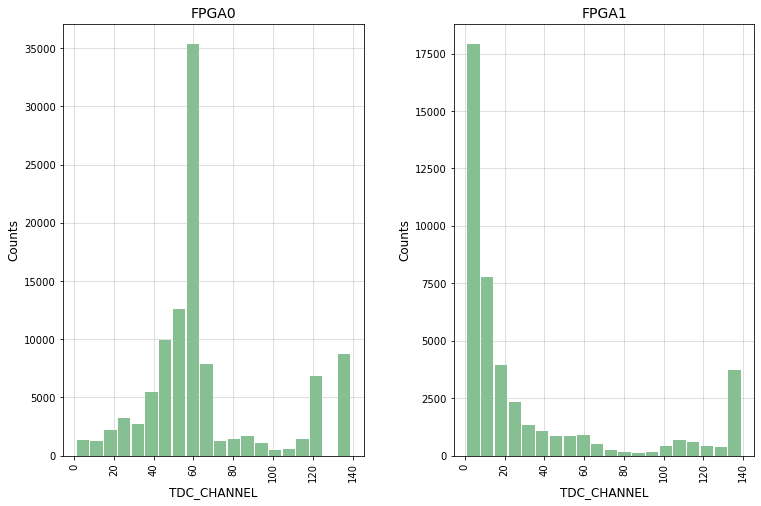

In [62]:
import matplotlib.pyplot as plt

ax = data.hist(column = 'TDC_CHANNEL', by = 'FPGA', bins = 20, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax[0].set_xlabel("TDC_CHANNEL", size = 12)
ax[0].set_ylabel("Counts", size = 12)
ax[0].set_title("FPGA0", size = 14)
ax[0].grid(alpha = 0.5)

ax[1].set_xlabel("TDC_CHANNEL", size = 12)
ax[1].set_ylabel("Counts", size = 12)
ax[1].set_title("FPGA1", size = 14)
ax[1].grid(alpha = 0.5)